**Script name** : Local Planner

**Description** : Multi-agent payload transport global planner based on APF.

**Author**      : Swapnil Kalhapure

**Email**       : kalhapure.swapnil@gmail.com

## Imports

In [16]:
import rospy
import cv2
import time
import tf2_ros
import tf2_geometry_msgs
import numpy as np
import matplotlib.pyplot as plt
from nav_msgs.msg import Odometry
from nav_msgs.msg import Path
from nav_msgs.msg import OccupancyGrid
from geometry_msgs.msg import Twist
from scipy.ndimage.morphology import distance_transform_edt as bwdist
from scipy.ndimage.morphology import grey_dilation
from IPython.display import display, clear_output
from scipy.spatial import distance
from geometry_msgs.msg import PoseStamped
from tracking_pid.msg import FollowPathActionResult
from tracking_pid.msg import traj_point
import warnings
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
warnings.filterwarnings("ignore", category=RuntimeWarning) 

## Global variables

In [2]:
res_remap = 0.04

map_x = 0.0
map_y = 0.0
map_org_x = 0.0
map_org_y = 0.0
map_res = 0.0

got_path = False
goal_results = 0

mapdata = None
orgmapdata = None

globalpath = np.array([])
current_odom = None
agent_current_odom = None
pallet_pose = None

## Helper functions

In [3]:
def meters2grid(pose_m):
    pose_on_grid = np.array((np.array(pose_m) - [map_org_x, map_org_y])/ map_res)
    pose_on_grid[1] = map_y - pose_on_grid[1] 
    return pose_on_grid

In [4]:
def grid2meters(pose_grid):
    x = pose_grid[0] * (map_res) + map_org_x 
    y = (map_y - pose_grid[1]) * (map_res) + map_org_y 
    a = []
    a.append(float(x))
    a.append(float(y))
    return a

In [5]:
def get_position_in_grid(odom):
    tfbuffer = tf2_ros.Buffer()
    listener = tf2_ros.TransformListener(tfbuffer)
    t_a_b = tfbuffer.lookup_transform('map', odom.header.frame_id, rospy.Time(0), rospy.Duration(10.0))
    odom.pose = tf2_geometry_msgs.do_transform_pose(odom.pose, t_a_b)
    resp_odom = meters2grid((odom.pose.pose.position.x, odom.pose.pose.position.y))
    return resp_odom

In [6]:
def get_line(x1, y1, x2, y2):
    x1 = int(x1)
    y1 = int(y1)
    x2 = int(x2)
    y2 = int(y2)
    points = []
    issteep = abs(y2-y1) > abs(x2-x1)
    if issteep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
    rev = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        rev = True
    deltax = x2 - x1
    deltay = abs(y2-y1)
    error = int(deltax / 2)
    y = y1
    ystep = None
    if y1 < y2:
        ystep = 1
    else:
        ystep = -1
    for x in range(x1, x2 + 1):
        if issteep:
            points.append((y, x))
        else:
            points.append((x, y))
        error -= deltay
        if error < 0:
            y += ystep
            error += deltax
    # Reverse the list if the coordinates were reversed
    if rev:
        points.reverse()
    return points

In [7]:
def path_smoothing(path):
    current_point = 0 
    mapd = mapdata
    smoothedpath = []
    smoothedpath.append([path[current_point][0],path[current_point][1]])
    while (current_point <= len(path)):
        org_current_point = current_point
        for j in range(current_point,len(path)):
            point_lists = get_line(path[current_point][0],path[current_point][1],path[j][0],path[j][1])
            a = 0
            for i in range(len(point_lists)):
                if (mapd[point_lists[i][1],point_lists[i][0]] <= 0.0):
                    a = 1
                    current_point = j 
                    smoothedpath.append([path[j][0],path[j][1]])
                    break
            if (a == 1):
                break
        if (org_current_point == current_point):
            break
    smoothedpath.append([path[-1][0],path[-1][1]])
    return smoothedpath

## Controller

## ROS Code

In [10]:
def map_callback(data):
    global mapdata
    global orgmapdata
    global map_x
    global map_y
    global map_org_x
    global map_org_y
    global map_res
    global res_remap
    global goal_results
    global pallet_pose
    
    map_x = data.info.width
    map_y = data.info.height
    map_org_x = data.info.origin.position.x
    map_org_y = data.info.origin.position.y
    map_res = data.info.resolution
    
    orgmapdata = np.asarray(data.data).reshape(data.info.height,data.info.width).astype(np.uint8)
    orgmapdata = np.flip(orgmapdata,0)
    mapdata = orgmapdata
    mapdata = np.where(mapdata<254,mapdata,0)
    mapdata = grey_dilation(mapdata,size=(int(res_remap*map_y),int(res_remap*map_x)))
    mapdata = np.invert(mapdata)
    mapdata = cv2.threshold(mapdata, 200, 255, cv2.THRESH_BINARY)[1]


def path_callback(data):
    global mapdata
    global globalpath
    global current_odom
    global agent_current_odom
    global img_no
    global robot_namespace
    print("Got the Global path")
    globalpath = []
    x = []
    y = []
    for i in range(len(data.poses)):
        ans = meters2grid((data.poses[i].pose.position.x,
                           data.poses[i].pose.position.y))
        x.append(int(ans[0]))
        y.append(int(ans[1]))
    globalpath.append(x)
    globalpath.append(y)
    globalpath=np.array(globalpath)
    final_point = globalpath[:,-1]


def odom_callback(data):
    global current_odom
    current_odom = data

def agent_odom_callback(data):
    global agent_current_odom
    agent_current_odom = data

def pallet_odom_callback(data):
    global pallet_pose
    pallet_pose = data

rospy.init_node('LocalPlanner')
rospy.Subscriber("/map", OccupancyGrid, map_callback)
rospy.Subscriber("/jackal0/global_path", Path, path_callback)
rospy.Subscriber("/jackal0/odometry/local_filtered", Odometry, odom_callback)
rospy.Subscriber("/jackal1/odometry/local_filtered", Odometry, agent_odom_callback)
rospy.Subscriber("/pallet_pose", Odometry, pallet_odom_callback)
trajectory_pub = rospy.Publisher("/jackal0/trajectory", traj_point, queue_size=1)
robot_namespace = "jackal0"#rospy.get_param("~robot_namespace")

Got the Global path


In [164]:

class local_region:
    def __init__(self, origin_x, origin_y, width=200):
        self.org_x = origin_x
        self.org_y = origin_y
        self.data = None
        self.attractive = None
        self.repulsive = None
        self.global_path_start = 0
        self.path = []
        self.data = mapdata[origin_y-width:origin_y+width,origin_x-width:origin_x+width]
        
    def local_coordinate_convert(self,data):
        return (data - (self.get_origin() - np.array([200,200])))
    
    def global_coordinate_convert(self,data):
        return (data + (self.get_origin() - np.array([200,200])))
        
    def set_map_data(self,data):
        self.data = data
        
    def get_map_data(self):
        return self.data
    
    def get_target_data(self):
        return self.global_coordinate_convert(self.target)
    
    def get_target_local_data(self):
        return self.target
    
    def get_local_path(self):
        return self.path
    
    def get_origin(self):
        return [self.org_x,self.org_y]
    
    def extract_local_path(self,path):
        self.path = []
        for i in range(self.global_path_start,len(path[0])):
            ans =  self.local_coordinate_convert(np.array([path[0,i],path[1,i]]))
            if ans[0]>=0 and ans[1]>=0 and ans[0]<=400 and ans[1]<=400:
                self.path.append(np.array([ans[0],ans[1]]))
            else : 
                break
        self.path=np.asarray(self.path)
        self.target = self.path[0,:]
        return self.path
    
    def extract_immediate_goal(self,global_path):
        ans = []
        for i in range(len(self.path[:,0])):
            ans.append(distance.euclidean([200,200], self.path[i,:]))
        if (np.min(ans) < 40):
            delete_point = self.global_coordinate_convert(self.path[np.argmin(ans),:])
            ay = np.where(global_path==np.array([[delete_point[0]],[delete_point[1]]]))[1][0] + 1
            self.target = self.local_coordinate_convert(global_path[:,0])
            global_path = np.delete(global_path,np.s_[0:ay],axis=1)
            self.path = np.delete(self.path, np.argmin(ans),axis=0)
            self.path = np.delete(self.path,np.s_[0:np.argmin(ans)],axis=0)
        return self.target,global_path
    
    def compute_map_repulsive_force(self, influence_radius = 2, repulsive_coef = 100):
        mod_map = np.copy(self.data)
        bdist = bwdist(mod_map==255)
        bdist2 = (bdist/100.) + 1
        repulsive = repulsive_coef*((1./bdist2 - 1./influence_radius)**2)
        repulsive [bdist2 > influence_radius] = 0
        return repulsive

    def compute_repulsive_force(self, objects= [[200,200]], influence_radius = 2, repulsive_coef = 100):
        mod_map = np.ones((400, 400), np.uint8)
        mod_map = mod_map * 255
        for i in range(len(objects)):
            cv2.circle(mod_map, (objects[i][0],objects[i][1]), 5, 0, -1)
        if (len(objects) > 1) :
            cv2.line(mod_map,(objects[0][0],objects[0][1]),(objects[1][0],objects[1][1]),0,5)
        bdist = bwdist(mod_map==255)
        bdist2 = (bdist/100.) + 1
        repulsive = repulsive_coef*((1.0/bdist2 - 1.0/influence_radius)**2)
        repulsive [bdist2 > influence_radius] = 0
        return repulsive
    
    def compute_attractive_force(self, goal = [200,200], influence_radius = 0.5,coef = 100.0):
        img = np.ones((400, 400), np.uint8)
        img = img * 255
        cv2.circle(img, (goal[0],goal[1]), 8, 0, -1)
        bdist = bwdist(img==255)
        bdist2 = (bdist/100.) + 1
        repulsive = -coef * ((1./bdist2 - 1./influence_radius)**2)
        repulsive [bdist2 > influence_radius] = 0
        return repulsive

    def visualize_forces (self, force):
        skip = 5
        sizer = 400
        [x_m, y_m] = np.meshgrid(np.linspace(1, sizer,sizer), np.linspace(1, sizer,sizer))
        [gy, gx] = np.gradient(force)
        gx = -gx
        q_stack = x_m[::skip, ::skip], y_m[::skip, ::skip], gx[::skip, ::skip], gy[::skip, ::skip]
        plt.figure(figsize=(15,15))
        plt.imshow(self.data)
        plt.quiver(x_m[::skip, ::skip], y_m[::skip, ::skip], gx[::skip, ::skip], gy[::skip, ::skip])
        return plt
    
    def gradient_planner (self, force, start_coords):
        [gy, gx] = np.gradient(-force)
        route = np.array([np.array(start_coords)])
        ix = 0
        iy = 0
        max_itr = 0
        while(((ix < len(gx)-2) and (ix < len(gy)-2)) and max_itr < 15):
            current_point = route[-1,:]
            if ( not np.isnan(current_point[0]) and not np.isnan(current_point[1])):
                ix = int( current_point[1] )
                iy = int( current_point[0] )
                vx = gx[ix, iy]
                vy = gy[ix, iy]
                dt = 1 / np.linalg.norm([vx, vy])
                next_point = current_point + dt*np.array( [vx, vy] )
                route = np.vstack( [route, next_point] ) 
                max_itr = max_itr + 1 
            else:
                break
        return route

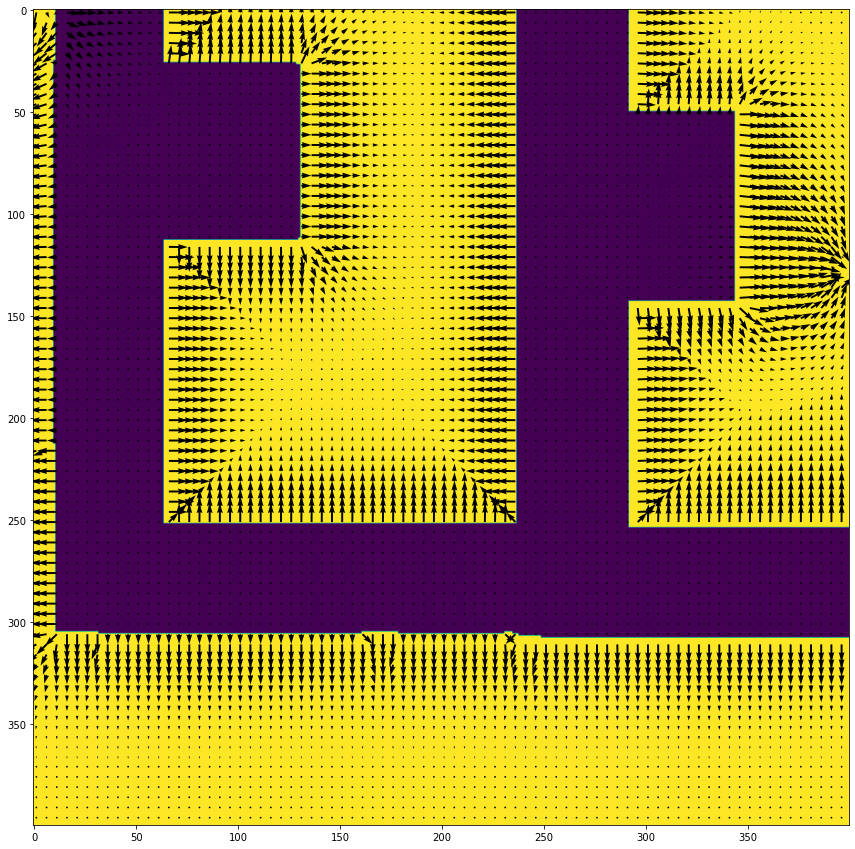

In [185]:
cmd = traj_point()
co = get_position_in_grid(current_odom).astype(np.uint16)
a = local_region(co[0],co[1])
objects_in_region = []
if type(None) != type(pallet_pose):
    localpallet = get_position_in_grid(pallet_pose).astype(np.uint16)
    localpallet = a.local_coordinate_convert(localpallet)
    objects_in_region.append(localpallet)

if type(None) != type(agent_current_odom):
    other_agent = get_position_in_grid(agent_current_odom).astype(np.uint16)
    other_agent = a.local_coordinate_convert(other_agent)
    objects_in_region.append(other_agent)
a.extract_local_path(globalpath)
localtarget , globalpath= a.extract_immediate_goal(globalpath)
forces = 0
forces = forces + a.compute_map_repulsive_force(influence_radius = 2.1, repulsive_coef = 4.5)
forces = forces + a.compute_repulsive_force(objects = objects_in_region,influence_radius = 2.5,repulsive_coef = 4.5)
forces = forces + a.compute_attractive_force(goal = localtarget, influence_radius = 5.5, coef=2.5)
no_problem = True
viz_plot = a.visualize_forces(forces)



## Control Loop

while True:
    if (globalpath.size > 1):
        print("inside this")
        co = get_position_in_grid(current_odom).astype(np.uint16)
        a = local_region(co[0],co[1])
        objects_in_region = []
        if type(None) != type(pallet_pose):
            localpallet = get_position_in_grid(pallet_pose).astype(np.uint16)
            localpallet = a.local_coordinate_convert(localpallet)
            objects_in_region.append(localpallet)

        if type(None) != type(agent_current_odom):
            other_agent = get_position_in_grid(agent_current_odom).astype(np.uint16)
            other_agent = a.local_coordinate_convert(other_agent)
            objects_in_region.append(other_agent)
        a.extract_local_path(globalpath)
        localtarget , globalpath= a.extract_immediate_goal(globalpath)
        forces = 0
        forces = forces + a.compute_repulsive_force(objects = 
                                                    objects_in_region,influence_radius = 2, repulsive_coef = 2.0)
        forces = forces + a.compute_attractive_force(goal = localtarget, influence_radius = 3, coef=1.5)
        route = a.gradient_planner(forces,[200,200])
        viz_plot = a.visualize_forces(forces)
        viz_plot.plot(route[:,0],route[:,1],"go--",linewidth=3,markersize=10,label="Local Path")
        viz_plot.plot(a.get_local_path()[:,0],a.get_local_path()[:,1],"bo--",linewidth=3,markersize=10,label="Global Path")
        if type(None) != type(pallet_pose):
            viz_plot.plot(localpallet[0],localpallet[1],"co",markersize=15,label="Pallet")
        viz_plot.plot(localtarget[0],localtarget[1],"mo",markersize=15,label="Local Target")
        if type(None) != type(agent_current_odom):
            viz_plot.plot(agent_loc[0],agent_loc[1],"ro",markersize=15,label="Other agent")
        viz_plot.plot(200,200,"rX",markersize=15,label="Robot")
        plt.legend(loc="upper left",labelspacing=1,prop={'weight':'bold'},facecolor="w",framealpha=1)
        viz_plot.show()


## Test code

skip = 5
sizer = 400

img = np.ones((400, 400), np.uint8)
img = img * 0
cv2.circle(img, (200,200), 30, 255, 2)
bdist = bwdist(img==0) # 255 for repl
bdist2 = (bdist/100.0) + 1
repulsive = -100 * ((1./bdist2 - 1./.2)**2)
repulsive [bdist2 > 2] = 0
[x_m, y_m] = np.meshgrid(np.linspace(1, sizer,sizer), np.linspace(1, sizer,sizer))
[gy, gx] = np.gradient(repulsive);
gx = -gx
q_stack = x_m[::skip, ::skip], y_m[::skip, ::skip], gx[::skip, ::skip], gy[::skip, ::skip]
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.quiver(x_m[::skip, ::skip], y_m[::skip, ::skip], gx[::skip, ::skip], gy[::skip, ::skip])

print(np.max(repulsive))
print(np.min(repulsive))

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

xx, yy = np.mgrid[0:400, 0:400]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(xx, yy, repulsive)

plt.show()

p = True
t = 0
path_goal_pose = [globalpath[0][t],globalpath[1][t]]
pallet_pose = [300,300]
while p:
    co = meters2grid([current_odom.pose.pose.position.x,current_odom.pose.pose.position.y]).astype(np.uint16)
    a = local_region(co[0],co[1])
    r = a.compute_forces(goal = path_goal_pose, 
                         pallet_goal = pallet_pose,
                         influence_radius = 2, 
                         repulsive_coef = 2200, 
                         attractive_coef = 1./100)
    
    test = a.visualize_forces()
    route = a.gradient_planner([200,200])
    w=a.extract_local_path(globalpath)
    plt.plot(w[:,0],w[:,1],"bo")
    test.plot(route[:,0],route[:,1],"yo--")
    test.plot(200,200,"go")
    test.plot(pallet_pose[0],pallet_pose[1],"ro")
    test.show()
    
    display(test)
    clear_output(wait = True)

plt.figure(figsize=(15,15))
plt.imshow(mapdata)
plt.grid(True)
plt.plot(globalpath[0],globalpath[1],"bo--")
plt.plot(a.get_origin()[0],a.get_origin()[1],"ro")
plt.plot(a.get_target_data()[0],a.get_target_data()[1],"go")
plt.plot(np.array(global_route)[:,0],np.array(global_route)[:,1],"rx")
dx = a.get_origin()[0] - a.get_target_data()[0]
dy = a.get_origin()[1] - a.get_target_data()[1]
dx = int(dx * -20) + a.get_origin()[0]
dy = int(dy * -20) + a.get_origin()[1]
plt.plot(dx,dy,"yo")
plt.show()

co = meters2grid([current_odom.pose.pose.position.x,current_odom.pose.pose.position.y]).astype(np.uint16)
a = local_region(co[0],co[1])
r = a.compute_forces(goal=[50,50],pallet_goal = [50,50],influence_radius = 2, 
                                                        repulsive_coef = 2200, 
                                                        attractive_coef = 1./100)
test = a.visualize_forces()
test.show()

tt = 2
a = local_region(globalpath[0][tt],globalpath[1][tt])
path_goal_pose = [200,800]
pallet_pose = [300,300]
robot_pose = [200,200]
r = a.compute_forces(goal=path_goal_pose,pallet_goal = pallet_pose,influence_radius = 2, 
                                                        repulsive_coef = 2200, 
                                                        attractive_coef = 1./100)
test = a.visualize_forces()
route = a.gradient_planner(robot_pose)
test.plot(route[:,0],route[:,1],"bo--")
test.plot(robot_pose[0],robot_pose[1],"go")
test.plot(pallet_pose[0],pallet_pose[1],"ro")
test.show()

## Garbage

plt.imshow(r)
plt.colorbar()

[x, y] = np.meshgrid(np.arange(50), np.arange(50))
ff = ((y - 25)**2) + ((x - 25)**2)

[px, py] = np.meshgrid(np.zeros(200), np.zeros(200))
fff= px+py

fff[(int((fff.shape[0]/2)-(ff.shape[0]/2))):int(((fff.shape[0]/2)+(ff.shape[0]/2))),
    (int((fff.shape[1]/2)-(ff.shape[1]/2))):int(((fff.shape[1]/2)+(ff.shape[1]/2)))]=ff
plt.imshow(fff)

[x, y] = np.meshgrid(np.arange(100), np.arange(100))
a = ((x - 50)**2) + ((y - 50)**2)
plt.imshow(a)
np.max(a)

np.vstack(a[:,0]).reshape(100)

[tx, ty] = np.meshgrid(np.ones(300), np.ones(300))

tx = tx*np.max(a)
tx[0:100,0:100]=5
tx[0:100,200:300]=5000
tx[200:300,0:100]=5000
tx[200:300,200:300]=5000
tx[100:200,0:100] = np.vstack(a[:,0])
tx[100:200,200:300] = np.vstack(a[:,0])
tx[0:100,100:200] = np.vstack(a[:,0]).reshape(100)
tx[200:300,100:200] = np.vstack(a[:,0]).reshape(100)
tx[100:200,100:200] = a

plt.imshow(cv2.blur(tx,(10,10)))
plt.colorbar()

skip= 5
[x_m, y_m] = np.meshgrid(np.linspace(1, 300,300), np.linspace(1, 300,300))
[gy, gx] = np.gradient(cv2.blur(tx,(10,10)));
gx = gx
q_stack = x_m[::skip, ::skip], y_m[::skip, ::skip], gx[::skip, ::skip], gy[::skip, ::skip]
plt.figure(figsize=(15,15))
plt.imshow(tx)
plt.colorbar()
plt.quiver(x_m[::skip, ::skip], y_m[::skip, ::skip], gx[::skip, ::skip], gy[::skip, ::skip])

[px, py] = np.meshgrid(np.arange(50), np.arange(50))

b = ((px - 25)**2) + ((py - 25)**2)

plt.imshow(b)
plt.colorbar()